In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
%matplotlib inline

In [2]:
#!pip install contractions
#!pip install textblob

In [3]:
data = pd.read_csv("C:/Users/aryan/OneDrive/Desktop/Python and CPP/Python Project/American Tourister Reviews Sentiment Analysis/AmazonTouristerReviewPosts_UK.csv", encoding = "latin1")
data.head()

,x
0,"Top quality luggage. Excellent luggage, good c..."
1,American Tourister Bon Air Suitcase. Love this...
2,Perfect case. The media could not be loaded.\r...
3,Its not as good as other American Tourister. I...
4,Not durable at all...cheap bendable plastic..m...


In [4]:
data.columns

Index(['x'], dtype='object')

In [5]:
import contractions

def expanded_contractions(text):
    return contractions.fix(text)

data['expanded'] = data['x'].apply(expanded_contractions)
data.head()

,x,expanded
0,"Top quality luggage. Excellent luggage, good c...","Top quality luggage. Excellent luggage, good c..."
1,American Tourister Bon Air Suitcase. Love this...,American Tourister Bon Air Suitcase. Love this...
2,Perfect case. The media could not be loaded.\r...,Perfect case. The media could not be loaded.\r...
3,Its not as good as other American Tourister. I...,Its not as good as other American Tourister. I...
4,Not durable at all...cheap bendable plastic..m...,Not durable at all...cheap bendable plastic..m...


In [6]:
stop_words = set(stopwords.words('english'))
def pre_processing(text):
    text = text.lower()
    text = re.sub(r'\b[not|no|never|nothing]\b[\s][a-z]*\b', lambda match: match.group().replace(" ","_", ), text)
    #text = re.sub(r'\bnot\b\s+(\w+)', r'not_\1', text)
    text = re.sub(r'[^a-z\s]', '', text, re.I|re.A)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    #tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

data['cleaned_text'] = data['expanded'].apply(pre_processing)
data.drop('expanded', inplace= True, axis = 1)
data.head()

,x,cleaned_text
0,"Top quality luggage. Excellent luggage, good c...",top quality luggage excellent luggage good cho...
1,American Tourister Bon Air Suitcase. Love this...,american tourister bon air suitcase love suitc...
2,Perfect case. The media could not be loaded.\r...,perfect case media could loaded ihave read man...
3,Its not as good as other American Tourister. I...,good american tourister iwould recomend hand l...
4,Not durable at all...cheap bendable plastic..m...,durable allcheap bendable plasticmy sisters br...


In [7]:
vectoriser = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectoriser.fit_transform(data['cleaned_text'])
dtm.shape

(934, 1189)

In [8]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [9]:
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topics

topics = display_topics(lda, vectoriser.get_feature_names_out(), 10)
print(topics)

{0: ['case', 'suitcase', 'great', 'quality', 'zip', 'cases', 'trip', 'lock', 'good', 'poor'], 1: ['perfect', 'suitcase', 'nice', 'robust', 'luggage', 'light', 'bag', 'case', 'easily', 'lightweight'], 2: ['case', 'suitcase', 'zip', 'lock', 'handle', 'ihave', 'used', 'time', 'wheels', 'use'], 3: ['great', 'good', 'stars', 'product', 'case', 'suitcase', 'excellent', 'colour', 'quality', 'really'], 4: ['good', 'easy', 'case', 'sturdy', 'lightweight', 'quality', 'light', 'suitcase', 'great', 'looks']}


In [10]:
def get_topic_numerical(model, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[topic_idx] = topic[:no_top_words]
    return topics

numerical_topics = get_topic_numerical(lda, 10)
numerical_topics_df = pd.DataFrame(numerical_topics)

In [11]:
numerical_topics_df

,0,1,2,3,4
0,3.310540,0.200933,7.085304,0.202735,0.200487
1,0.200797,0.200315,9.117337,0.200448,1.281103
2,2.655894,0.207264,3.194196,0.200011,1.742635
3,4.036713,0.529471,5.135830,3.376719,1.921267
4,4.195523,1.199972,0.201222,0.200004,0.203279
5,0.200002,0.200003,1.200084,0.200002,1.199908
6,0.201935,0.203592,5.957747,1.436066,0.200661
7,1.196756,0.211883,3.184478,0.203607,0.203276
8,0.200002,0.200002,2.199994,0.200002,0.200001
9,0.202064,0.668356,1.199666,1.729908,0.200006


Text(83.22222222222221, 0.5, 'Topics')

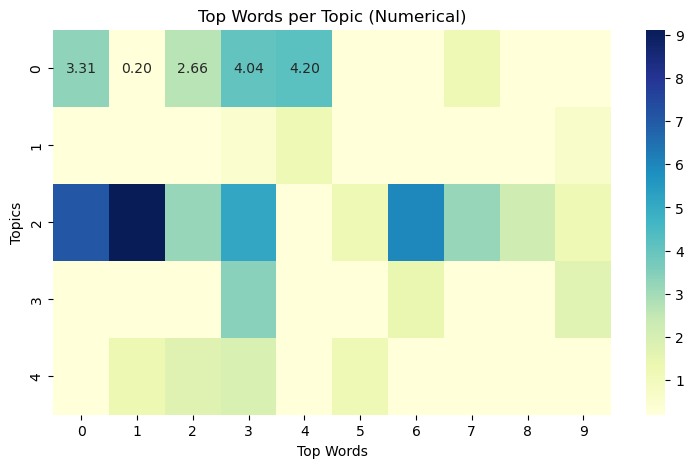

In [12]:
plt.figure(figsize=(9,5))
sns.heatmap(data = numerical_topics_df.T, annot= True, cmap = 'YlGnBu', fmt= '.2f')
plt.title('Top Words per Topic (Numerical)')
plt.xlabel('Top Words')
plt.ylabel('Topics')

In [13]:
data['sentiment'] = data['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

C:\Users\aryan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

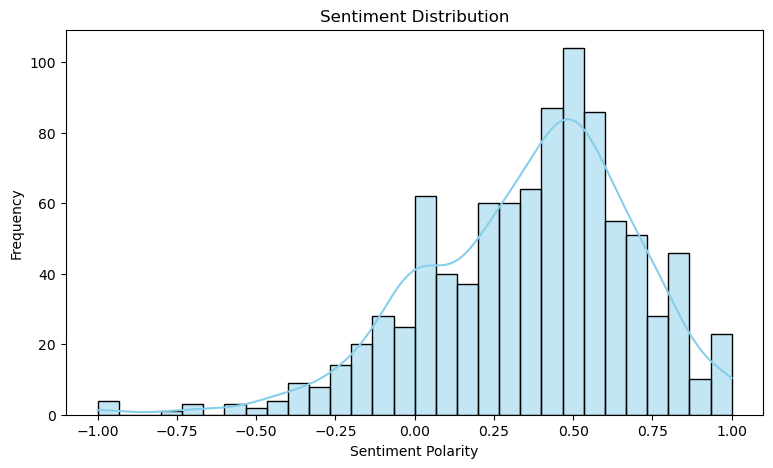

In [14]:
plt.figure(figsize=(9, 5))
sns.histplot(data['sentiment'], bins=30, kde=True, color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')

In [15]:
sentiment_summary = data['sentiment'].describe()
sentiment_summary

count    934.000000
mean       0.360572
std        0.331844
min       -1.000000
25%        0.154514
50%        0.407083
75%        0.600000
max        1.000000
Name: sentiment, dtype: float64

In [16]:
data.head()

,x,cleaned_text,sentiment
0,"Top quality luggage. Excellent luggage, good c...",top quality luggage excellent luggage good cho...,0.528571
1,American Tourister Bon Air Suitcase. Love this...,american tourister bon air suitcase love suitc...,0.178571
2,Perfect case. The media could not be loaded.\r...,perfect case media could loaded ihave read man...,0.343457
3,Its not as good as other American Tourister. I...,good american tourister iwould recomend hand l...,0.128571
4,Not durable at all...cheap bendable plastic..m...,durable allcheap bendable plasticmy sisters br...,0.168651
